# Tests

In [6]:
library('dplyr')
library('ggplot2')
library('ggrepel')
library('xtable')
library('tidyr')
library('xtable')
library('purrr')
library('readr')
library('tseries')
#install.packages('flextable')
library('kableExtra')
options("scipen"=100, "digits"=4)
library('flextable')

In [8]:
source('PortfolioFunctions_v7.R')

In [9]:
# reading datasets
down <- read.csv('df_down_1999.csv') %>%
  mutate(Date=as.Date(Date, format = "%Y-%m-%d")) %>% 
  filter(Date >= '2000-01-01' & Date < '2021-01-01')

ftse100 <- read.csv('df_FTSE_1999.csv')%>%
  mutate(Date=as.Date(Date, format = "%Y-%m-%d")) %>% 
  filter(Date >= '2000-01-01' & Date < '2021-01-01')

dax <- read.csv('df_DAX_1999.csv')%>%
  mutate(Date=as.Date(Date, format = "%Y-%m-%d")) %>% 
  filter(Date >= '2000-01-01' & Date < '2021-01-01') 

sp500 <- read.csv('df_S&P500_1999.csv')%>%
  mutate(Date=as.Date(Date, format = "%Y-%m-%d")) %>% 
  filter(Date >= '2000-01-01' & Date < '2021-01-01')  

nasdaq <- read.csv('df_NASDAQ_1999.csv')%>%
  mutate(Date=as.Date(Date, format = "%d/%m/%Y")) %>% 
  filter(Date >= '2000-01-01' & Date < '2021-01-01') %>% 
  select(-HSKA)

nasdaqETFs <- read.csv('df_NASDAQ.ETF_1999.csv')%>%
  mutate(Date=as.Date(Date, format = "%d/%m/%Y")) %>% 
  filter(Date >= '2000-01-01' & Date < '2021-01-01') 

nyse <- read.csv('df_NYSE_1999.csv')%>%
  mutate(Date=as.Date(Date, format = "%d/%m/%Y")) %>% 
  filter(Date >= '2000-01-01' & Date < '2021-01-01') %>% select(-AIG, -BAC, -AEG, -BIG, -BDN, -BBVA, -AWR, -AME, -AFL)

In [10]:
bases <- list('DJIA' = down,
              'FTSE100' = ftse100, 
              'DAX' = dax, 
              'NASDAQ' = nasdaq,
              'NASDAQ(ETFs)'= nasdaqETFs,
              'NYSE'= nyse,
              'S&P500' = sp500)

indices <- names(bases)
base.complete <- NULL
for(i in 1:length(indices)){
  base.i <- getReturns(bases[[i]]) %>% 
    pivot_longer(!Fecha, names_to='Stock', values_to='Return') %>% 
    mutate('Index' = indices[i])
  base.complete <- rbind(base.complete, base.i)
} 

In [11]:
head(base.complete)

Fecha,Stock,Return,Index
<date>,<chr>,<dbl>,<chr>
2000-01-04,WMT,-0.03814,DJIA
2000-01-04,MRK,-0.03575,DJIA
2000-01-04,INTC,-0.04782,DJIA
2000-01-04,MSFT,-0.03436,DJIA
2000-01-04,MMM,-0.04055,DJIA
2000-01-04,AAPL,-0.08808,DJIA


In [12]:
base.stocks <- base.complete %>% 
    group_by(Index, Stock) %>%
    summarise(#n = n(), 
              mean = mean(Return), 
              sd = sd(Return),
              sr = mean / sd, 
              min = min(Return),
              max = max(Return),
              skeness = skewness(Return),
              kurtosis = kurtosis(Return)) %>%
    ungroup()%>%data.frame()
head(base.stocks)

`summarise()` has grouped output by 'Index'. You can override using the `.groups` argument.



,Index,Stock,mean,sd,sr,min,max,skeness,kurtosis
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,DAX,ADS.DE,0.000523820,0.01927,0.0271851,-0.1669,0.1280,-0.08977,9.860
2,DAX,ALV.DE,-0.000086590,0.02196,-0.0039430,-0.1664,0.2331,0.12791,13.271
3,DAX,BAS.DE,0.000175095,0.01852,0.0094532,-0.1467,0.1764,0.06610,9.873
4,DAX,BAYN.DE,0.000007209,0.02043,0.0003528,-0.1941,0.3301,0.38243,21.660
5,DAX,BMW.DE,0.000169115,0.02100,0.0080522,-0.1414,0.1384,-0.03410,7.875
6,DAX,CON.DE,0.000350842,0.02476,0.0141690,-0.2276,0.3329,0.44738,18.221


In [13]:
# make latex table
latex_table <- base.stocks %>%
  #filter(Year %in% c(2007:2009, 2018:2020)) %>% 
  kbl(format="latex",
      col.names = colnames(base.stocks),
      align="r",
      caption="Descriptive Statistic") %>%
  kable_minimal(full_width = F,  html_font = "Source Sans Pro")

Warning message:
"ggrepel: 24 unlabeled data points (too many overlaps). Consider increasing max.overlaps"
Warning message:
"ggrepel: 10 unlabeled data points (too many overlaps). Consider increasing max.overlaps"
Warning message:
"ggrepel: 16 unlabeled data points (too many overlaps). Consider increasing max.overlaps"
Warning message:
"ggrepel: 19 unlabeled data points (too many overlaps). Consider increasing max.overlaps"
Warning message:
"ggrepel: 4 unlabeled data points (too many overlaps). Consider increasing max.overlaps"
Warning message:
"ggrepel: 15 unlabeled data points (too many overlaps). Consider increasing max.overlaps"


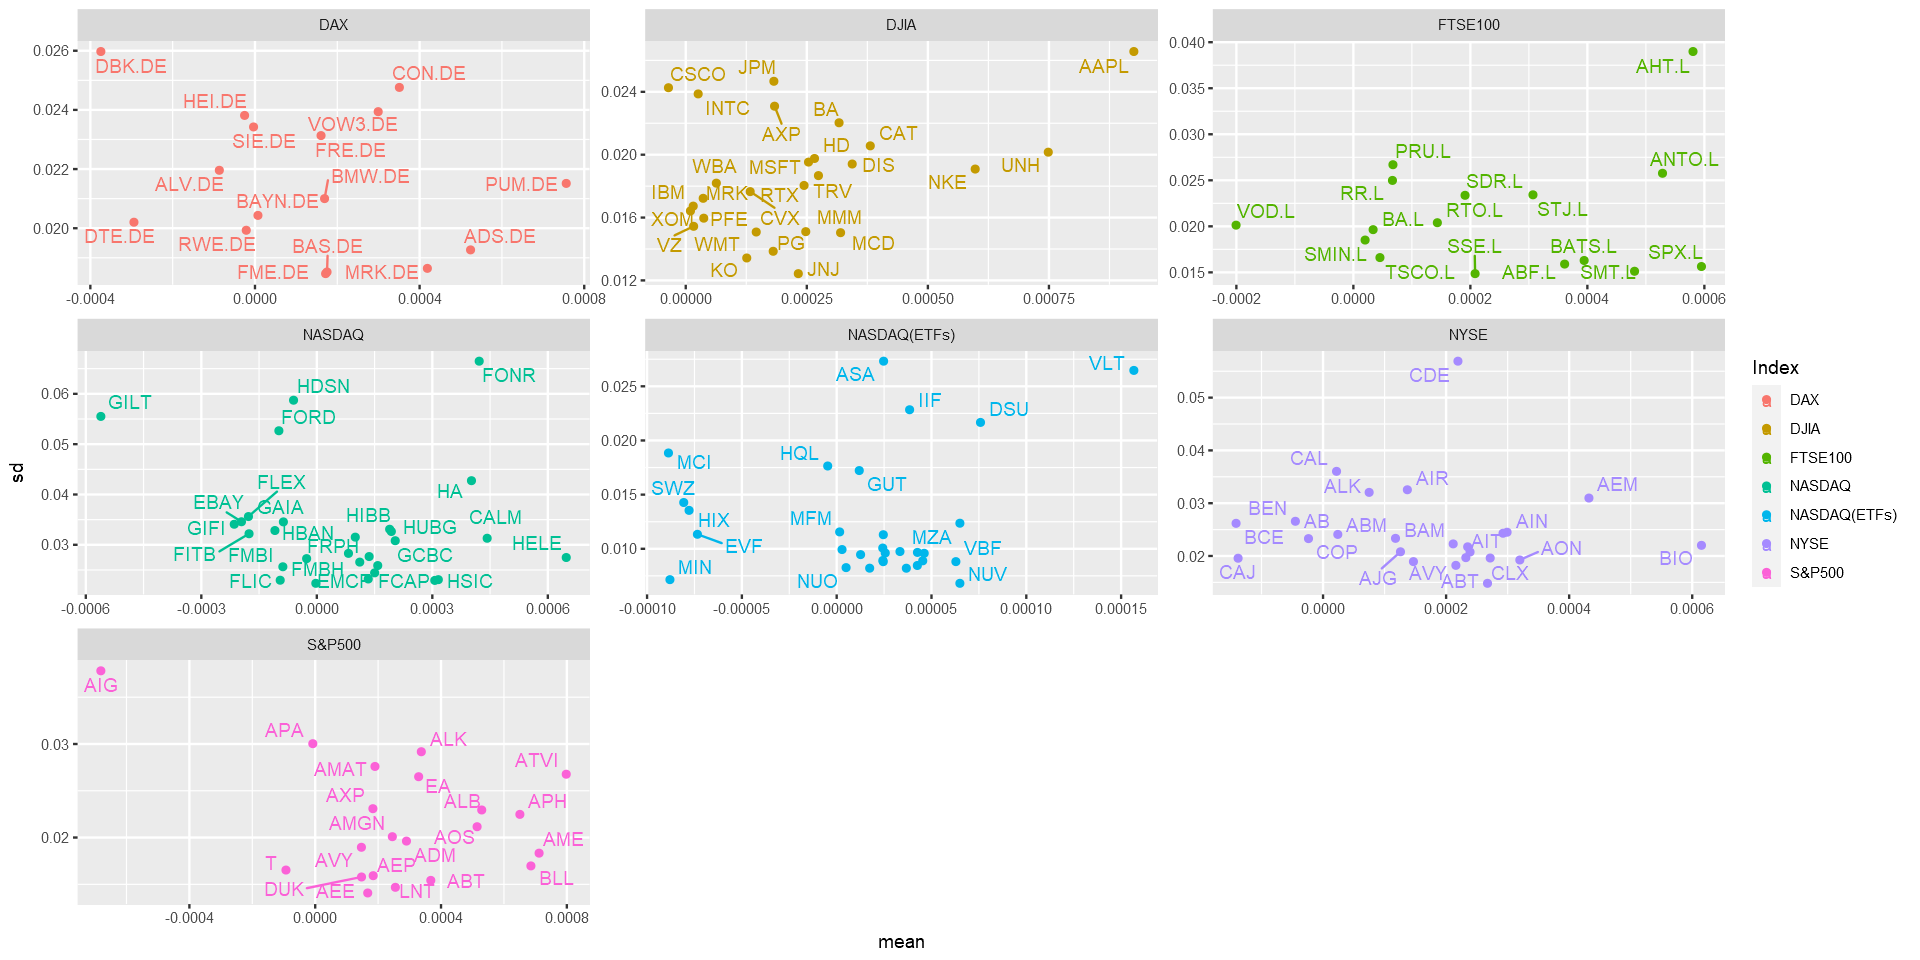

In [14]:
options(repr.plot.width=16, repr.plot.height=8)
p0 <- ggplot(base.stocks, aes(x=mean, y=sd, color=Index)) +
    geom_point() +
    facet_wrap(vars(Index), scale="free") +
    geom_text_repel(aes(label=Stock))
p0

## La prueba de Ljung-Box 

Se emplea para comprobar si una serie de observaciones en un período de tiempo específico son aleatorias e independientes. Si las observaciones no son independientes, una observación puede estar correlacionada con otra observación $k$ unidades de tiempo después, una relación que se denomina autocorrelación. 

\begin{equation}
H_0 : \rho_1 = ... = \rho_k = 0
\end{equation}
with the statistic
\begin{equation}
Q  =  n(n+2) \sum_{k=1}^{m} \frac{\hat{\rho}_k^2}{(n-k)} 
\end{equation} 
where $m$ is the number of lags under test, and $\hat{\rho}_k^2$ represents $\hat{Cov} (r_t, r_{t+k})$ for $k=1,...,m$. 

In [25]:
ljungBox_test <- base.complete %>% 
  mutate('year' = as.numeric(substring(Fecha, 1, 4))) %>%
  group_by(year, Index, Stock) %>% 
  summarise(Return = list(Return)) %>%  
  group_by(year, Index, Stock) %>% 
  mutate(Statistic = round(Box.test(unlist(Return), lag=25, type="Ljung-Box")$statistic,4),
         P.value = round(Box.test(unlist(Return), lag=25, type="Ljung-Box")$p.value,4)) %>% 
  select(-Return) %>%        
  data.frame() %>% 
  mutate('Sig(5%)' = ifelse( P.value < 0.05, "*", ""),
         'Sig(10%)' = ifelse( P.value < 0.10, "*", "")) %>% 
         filter(year >= 2017, year<=2020)
head(ljungBox_test) 

`summarise()` has grouped output by 'year', 'Index'. You can override using the `.groups` argument.



,year,Index,Stock,Statistic,P.value,Sig(5%),Sig(10%)
,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>
1,2017,DAX,ADS.DE,37.58,0.0508,,*
2,2017,DAX,ALV.DE,42.05,0.0177,*,*
3,2017,DAX,BAS.DE,27.58,0.3277,,
4,2017,DAX,BAYN.DE,19.25,0.7848,,
5,2017,DAX,BMW.DE,25.83,0.4167,,
6,2017,DAX,CON.DE,17.68,0.8557,,


In [20]:
ljungBox_test_Down <- ljungBox_test  %>% 
    filter(Index == 'DJIA') %>% 
    select(-Statistic, -P.value) %>% 
    pivot_wider(names_from='Stock', values_from='Sig(5%)', values_fill = "") 

ljungBox_test_Down

year,Index,Sig(10%),AAPL,AXP,BA,CAT,CSCO,CVX,DIS,...,NKE,PFE,PG,RTX,TRV,UNH,VZ,WBA,WMT,XOM
<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,...,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
2017,DJIA,,,,,,,,,...,,,,,,,,,,
2017,DJIA,*,,,,,,,*,...,,,,*,,,,,,
2018,DJIA,,,,,,,,,...,,,,,,,,,,
2018,DJIA,*,,,,*,,,,...,*,,,,,,,,,
2019,DJIA,,,,,,,,,...,,,,,,,,,,
2019,DJIA,*,,,,*,,,,...,,,,,,,,,,
2020,DJIA,*,*,*,,*,*,*,*,...,*,*,*,*,*,*,*,*,*,*


In [21]:
ljungBox_test_Down <- ljungBox_test  %>% 
    filter(Index == 'DAX') %>% 
    select(-Statistic, -P.value) %>% 
    pivot_wider(names_from='Stock', values_from='Sig(5%)', values_fill = "") 

ljungBox_test_Down

year,Index,Sig(10%),ADS.DE,ALV.DE,BAS.DE,BAYN.DE,BMW.DE,CON.DE,DBK.DE,DTE.DE,FME.DE,FRE.DE,HEI.DE,MRK.DE,PUM.DE,RWE.DE,SIE.DE,VOW3.DE
<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
2017,DAX,*,,*,,,,,,,,,,,,,,*
2017,DAX,,,,,,,,,,,,,,,,,
2018,DAX,,,,,,,,,,,,,,,,,
2018,DAX,*,,,,*,,,,,,,,,,,,
2019,DAX,,,,,,,,,,,,,,,,,
2019,DAX,*,,,,,,,,,,,,*,,,,
2020,DAX,*,*,*,*,,*,*,*,*,,*,*,,*,,,*
2020,DAX,,,,,,,,,,,,,,,,,


In [22]:
ljungBox_test_FTSE100 <- ljungBox_test  %>% 
    filter(Index == 'FTSE100') %>% 
    select(-Statistic, -P.value) %>% 
    pivot_wider(names_from='Stock', values_from='Sig(5%)', values_fill = "") 

ljungBox_test_FTSE100

year,Index,Sig(10%),ABF.L,AHT.L,ANTO.L,BA.L,BATS.L,PRU.L,RR.L,RTO.L,SDR.L,SMIN.L,SMT.L,SPX.L,SSE.L,STJ.L,TSCO.L,VOD.L
<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
2017,FTSE100,,,,,,,,,,,,,,,,,
2018,FTSE100,,,,,,,,,,,,,,,,,
2019,FTSE100,,,,,,,,,,,,,,,,,
2020,FTSE100,,,,,,,,,,,,,,,,,
2020,FTSE100,*,,*,*,*,*,*,*,*,*,*,*,,*,*,,*


## Prueba de Dickey-Fuller Aumentada (ADF)
> - $H_0$ :  existencia de raíz unitaria (serie no estacionaria)
> - $H_a$ :  no existencia de raíz unitaria (serie estacionaria)

In [26]:
adf_test <- base.complete %>% 
  mutate('year' = as.numeric(substring(Fecha, 1, 4))) %>%
  group_by(year, Index, Stock) %>% 
  summarise(Return = list(Return)) %>% 
  mutate(Statistic = round(adf.test(unlist(Return))$statistic,4),
         P.value = round(adf.test(unlist(Return))$p.value,4))  %>% 
  select(-Return) %>%        
  data.frame() %>% 
  mutate('Sig(5%)' = ifelse( P.value < 0.05, "*", "")
         #'Sig(10%)' = ifelse( P.value < 0.10, "*", "")
         ) %>% 
         filter(year >= 2017, year<=2020)
head(adf_test)

`summarise()` has grouped output by 'year', 'Index'. You can override using the `.groups` argument.

Warning message in adf.test(unlist(Return)):
"p-value smaller than printed p-value"
Warning message in adf.test(unlist(Return)):
"p-value smaller than printed p-value"
Warning message in adf.test(unlist(Return)):
"p-value smaller than printed p-value"
Warning message in adf.test(unlist(Return)):
"p-value smaller than printed p-value"
Warning message in adf.test(unlist(Return)):
"p-value smaller than printed p-value"
Warning message in adf.test(unlist(Return)):
"p-value smaller than printed p-value"
Warning message in adf.test(unlist(Return)):
"p-value smaller than printed p-value"
Warning message in adf.test(unlist(Return)):
"p-value smaller than printed p-value"
Warning message in adf.test(unlist(Return)):
"p-value smaller than printed p-value"
Warning message in adf.test(unlist(Return)):
"p-value smaller than printed p-value"
Warning message in adf.test(unlist(Return)):
"p-value small

,year,Index,Stock,Statistic,P.value,Sig(5%)
,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<chr>
1,2017,DAX,ADS.DE,-15.92,0.01,*
2,2017,DAX,ALV.DE,-15.92,0.01,*
3,2017,DAX,BAS.DE,-15.92,0.01,*
4,2017,DAX,BAYN.DE,-15.92,0.01,*
5,2017,DAX,BMW.DE,-15.92,0.01,*
6,2017,DAX,CON.DE,-15.92,0.01,*


In [30]:
adf_test_Down <- adf_test  %>% 
    filter(Index == 'DJIA') %>% 
    select(-Statistic, -P.value) %>% 
    pivot_wider(names_from='Stock', values_from='Sig(5%)', values_fill = NULL) 

adf_test_Down

year,Index,AAPL,AXP,BA,CAT,CSCO,CVX,DIS,HD,...,NKE,PFE,PG,RTX,TRV,UNH,VZ,WBA,WMT,XOM
<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,...,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
2017,DJIA,*,*,*,*,*,*,*,*,...,*,*,*,*,*,*,*,*,*,*
2018,DJIA,*,*,*,*,*,*,*,*,...,*,*,*,*,*,*,*,*,*,*
2019,DJIA,*,*,*,*,*,*,*,*,...,*,*,*,*,*,*,*,*,*,*
2020,DJIA,*,*,*,*,*,*,*,*,...,*,*,*,*,*,*,*,*,*,*


In [31]:
adf_test_DAX <- adf_test  %>% 
    filter(Index == 'DAX') %>% 
    select(-Statistic, -P.value) %>% 
    pivot_wider(names_from='Stock', values_from='Sig(5%)', values_fill = NULL) 

adf_test_DAX

year,Index,ADS.DE,ALV.DE,BAS.DE,BAYN.DE,BMW.DE,CON.DE,DBK.DE,DTE.DE,FME.DE,FRE.DE,HEI.DE,MRK.DE,PUM.DE,RWE.DE,SIE.DE,VOW3.DE
<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
2017,DAX,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*
2018,DAX,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*
2019,DAX,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*
2020,DAX,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*


In [33]:
adf_test_FTSE100 <- adf_test  %>% 
    filter(Index == 'FTSE100') %>% 
    select(-Statistic, -P.value) %>% 
    pivot_wider(names_from='Stock', values_from='Sig(5%)', values_fill = NULL) 

adf_test_FTSE100

year,Index,ABF.L,AHT.L,ANTO.L,BA.L,BATS.L,PRU.L,RR.L,RTO.L,SDR.L,SMIN.L,SMT.L,SPX.L,SSE.L,STJ.L,TSCO.L,VOD.L
<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
2017,FTSE100,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*
2018,FTSE100,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*
2019,FTSE100,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*
2020,FTSE100,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*
